In [ ]:
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, applications
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!mkdir choicedatasets

In [ ]:
# Navigate into Drive where you want to store your Kaggle data
os.chdir('/content/choicedatasets')
# Paste and run the copied API command, the data will download to the current directory
!kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

100% 11.5G/11.5G [02:53<00:00, 112MB/s] 
100% 11.5G/11.5G [02:53<00:00, 71.4MB/s]


['militaryaircraftdetectiondataset.zip']

In [ ]:
# Complete path to storage location of the .zip file of data
#zip_path = '/content/leafdata'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.getcwd()
# Copy the .zip file into the present directory
#!cp '{zip_path}' .
# Unzip quietly
!unzip -q '/content/choicedatasets/militaryaircraftdetectiondataset.zip'
# View the unzipped contents in the virtual machine
os.listdir()

['annotated_samples',
 'memo',
 'militaryaircraftdetectiondataset.zip',
 'crop',
 'dataset']

In [ ]:
# Load dataset
FILE_DIR = "/content/choicedatasets/crop"
DATA_PATH = pathlib.Path(FILE_DIR)

In [ ]:
SEED = 12345
IMG_SIZE = (128, 128)
BATCH_SIZE = 43
train_data = image_dataset_from_directory(DATA_PATH,
                                          validation_split=0.3,
                                          subset='training',
                                          seed=SEED,
                                          shuffle=True,
                                          image_size=IMG_SIZE,
                                          batch_size=BATCH_SIZE
                                          )

validation_data = image_dataset_from_directory(DATA_PATH,
                                               validation_split=0.3,
                                               subset='validation',
                                               seed=SEED,
                                               shuffle=True,
                                               image_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE)

Found 20596 files belonging to 46 classes.
Using 14418 files for training.
Found 20596 files belonging to 46 classes.
Using 6178 files for validation.


In [ ]:
# Split validation_data into validation & test set
val_batches = tf.data.experimental.cardinality(validation_data)
test_data = validation_data.take(val_batches//5)
val_data = validation_data.skip(val_batches//5)

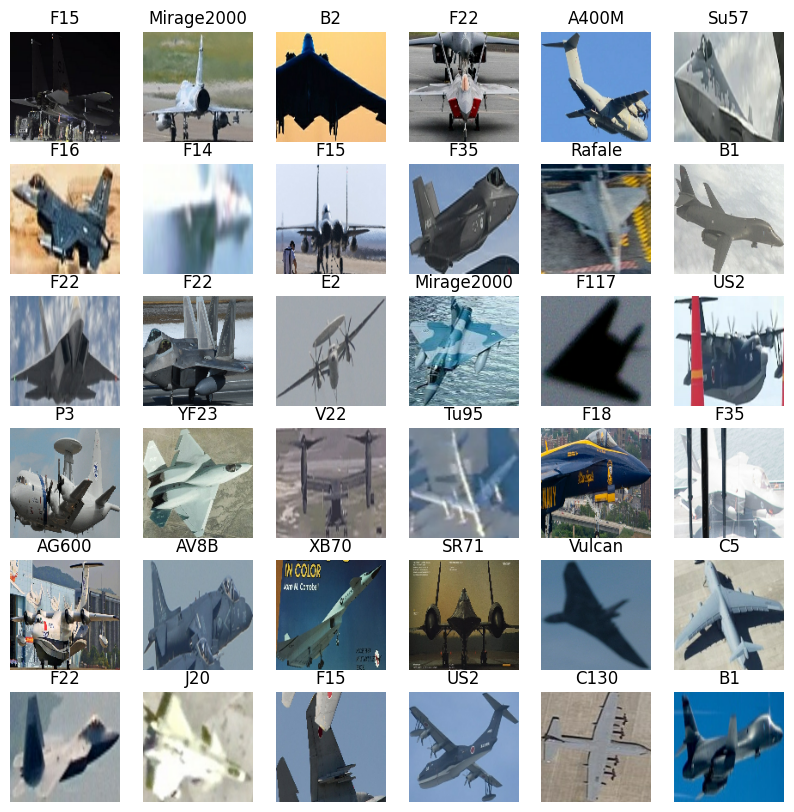

In [ ]:
# Display examples of data
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Create prefetch for train,test,val data
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_data.prefetch(buffer_size=AUTOTUNE)
pf_test = test_data.prefetch(buffer_size=AUTOTUNE)
pf_val = val_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Augmentation layer
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.4))

In [ ]:
# Feature extraction layer
# (a) Input processing
preprocess_input = applications.resnet50.preprocess_input

# (b) create base model using ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.ResNet50(input_shape=IMG_SHAPE,
                                   include_top=False,
                                   weights='imagenet')

# (c) Freeze layers
base_model.trainable = False
base_model.summary()

# (d) Classification layer
nClass = len(class_names)

global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nClass, activation='softmax')

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
# Chain layers with Functional api
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 128, 128, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
# Compile model
lr_schedule = optimizers.schedules.CosineDecay(0.001, 500)
optimizer = optimizers.Adam(learning_rate=lr_schedule)
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# Train Model
EPOCHS = 5
history = model.fit(pf_train, validation_data=(pf_val), epochs=EPOCHS)

Epoch 1/5
336/336 [==============================] - 118s 311ms/step - loss: 2.8396 - accuracy: 0.3023 - val_loss: 2.1394 - val_accuracy: 0.4337
Epoch 2/5
336/336 [==============================] - 70s 206ms/step - loss: 1.6795 - accuracy: 0.5419 - val_loss: 2.0560 - val_accuracy: 0.4517
Epoch 3/5
336/336 [==============================] - 70s 207ms/step - loss: 1.6356 - accuracy: 0.5567 - val_loss: 2.0655 - val_accuracy: 0.4491
Epoch 4/5
336/336 [==============================] - 91s 268ms/step - loss: 1.6356 - accuracy: 0.5567 - val_loss: 2.0636 - val_accuracy: 0.4513
Epoch 5/5
336/336 [==============================] - 73s 215ms/step - loss: 1.6356 - accuracy: 0.5567 - val_loss: 2.0678 - val_accuracy: 0.4487


In [ ]:
len(base_model.layers)

175

In [ ]:
# Finetune layer of base model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile model
optimizer = optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



In [ ]:
# Continue model training
fine_tune_epoch = 1
NEW_EPOCH = EPOCHS + fine_tune_epoch

history_fine = model.fit(pf_train,
                         validation_data=(pf_val),
                         epochs=NEW_EPOCH,
                         initial_epoch=history.epoch[-1])

Epoch 5/6
336/336 [==============================] - 90s 227ms/step - loss: 1.6987 - accuracy: 0.5490 - val_loss: 0.8934 - val_accuracy: 0.7455
Epoch 6/6
336/336 [==============================] - 98s 289ms/step - loss: 0.2352 - accuracy: 0.9469 - val_loss: 0.7227 - val_accuracy: 0.7979


In [ ]:
image_batch, label_batch = pf_test.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis = 1)

2/2 [==============================] - 2s 475ms/step


In [ ]:
lab_and_pred = np.transpose(np.vstack((label_batch, pred_labels)))
print(lab_and_pred)


[[20 20]
 [24 24]
 [32 32]
 [20 20]
 [40 40]
 [18 18]
 [17 17]
 [19 19]
 [ 2 41]
 [21 21]
 [10 10]
 [12 12]
 [39 39]
 [17 14]
 [17 17]
 [ 7  2]
 [23 25]
 [12 12]
 [36 36]
 [42 42]
 [ 3 22]
 [19 35]
 [44 44]
 [ 4  4]
 [17 17]
 [44 44]
 [17 17]
 [36 16]
 [17 17]
 [ 0  0]
 [25 25]
 [23 23]
 [35 35]
 [ 2  2]
 [11 11]
 [32 25]
 [41 41]
 [38 38]
 [19 19]
 [ 8 10]
 [ 9  9]
 [45 45]
 [17 17]]


In [ ]:
class_names


['A10',
 'A400M',
 'AG600',
 'AV8B',
 'B1',
 'B2',
 'B52',
 'Be200',
 'C130',
 'C17',
 'C2',
 'C5',
 'E2',
 'E7',
 'EF2000',
 'F117',
 'F14',
 'F15',
 'F16',
 'F18',
 'F22',
 'F35',
 'F4',
 'J10',
 'J20',
 'JAS39',
 'KC135',
 'MQ9',
 'Mig31',
 'Mirage2000',
 'P3',
 'RQ4',
 'Rafale',
 'SR71',
 'Su25',
 'Su34',
 'Su57',
 'Tornado',
 'Tu160',
 'Tu95',
 'U2',
 'US2',
 'V22',
 'Vulcan',
 'XB70',
 'YF23']

In [ ]:
data_labels_name =[]
for x in lab_and_pred:
  data_labels_name.append([class_names[i-1] for i in x])
data_labels_name

[['F18', 'F18'],
 ['J10', 'J10'],
 ['RQ4', 'RQ4'],
 ['F18', 'F18'],
 ['Tu95', 'Tu95'],
 ['F15', 'F15'],
 ['F14', 'F14'],
 ['F16', 'F16'],
 ['A400M', 'U2'],
 ['F22', 'F22'],
 ['C17', 'C17'],
 ['C5', 'C5'],
 ['Tu160', 'Tu160'],
 ['F14', 'E7'],
 ['F14', 'F14'],
 ['B52', 'A400M'],
 ['F4', 'J20'],
 ['C5', 'C5'],
 ['Su34', 'Su34'],
 ['US2', 'US2'],
 ['AG600', 'F35'],
 ['F16', 'Su25'],
 ['Vulcan', 'Vulcan'],
 ['AV8B', 'AV8B'],
 ['F14', 'F14'],
 ['Vulcan', 'Vulcan'],
 ['F14', 'F14'],
 ['Su34', 'F117'],
 ['F14', 'F14'],
 ['YF23', 'YF23'],
 ['J20', 'J20'],
 ['F4', 'F4'],
 ['Su25', 'Su25'],
 ['A400M', 'A400M'],
 ['C2', 'C2'],
 ['RQ4', 'J20'],
 ['U2', 'U2'],
 ['Tornado', 'Tornado'],
 ['F16', 'F16'],
 ['Be200', 'C17'],
 ['C130', 'C130'],
 ['XB70', 'XB70'],
 ['F14', 'F14']]